In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm, trange

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

# Reinforcement Learning summary:
Difference  to  supervised  learning
 
 • Time!
 
 • Feedback  is  given   as  a   scalar  reward, not as  the
correct action   to  make.
 
 • Feedback  is  usually not immediate   but is  given   after
many    actons  –   delayed feedback!

### Goal of RL

 • The   goal    in  reinforcement   learning    is  to  find
an  optimal  policy, i.e.,   state-action pairs   that
maximize    the reward.

 • To    do  this,   we  have    to  solve   the following
problems:

1. How  to  evaluate    how good    a   policy  is?

2. Which    policies    should  we  explore?

### How good a policy is:
Value function (V)

A   function V(s)    of  the state   that    tells   us  the value   of  being
in  the state   given   a   policy() i.e., the expected    amount
of  reward  we  get from    this    state   by  following   the policy)

   *  The value functon tells us how good a   policy  is. The
optimal  policy  has maximum V(s) for all states.
   *  When we start   learning we explore different   policies
and we have to learn    V(s)    for each    policy  as  it  is  unknown
before we   start   exploring   the environment.

In [3]:
import qlearning
from qlearning import show_path, show_qmat
from qlearning import LakeWorld, WindyLakeWorld, ZigZagWorld, Wormhole, FromLikePub, TempleRun, TheCake, TheMaze

In [4]:
w = LakeWorld()
print(w.size)

# Maps an immediate reward/cost for every position-action pair
Q = np.zeros(tuple(w.size) + (len(w.actions), ))
Q[:, 0, 0] = Q[:, -1, 1] = Q[-1, :, 2] = Q[0, :, 3] = -np.inf

V = np.max(Q, axis=-1)

[10 15]


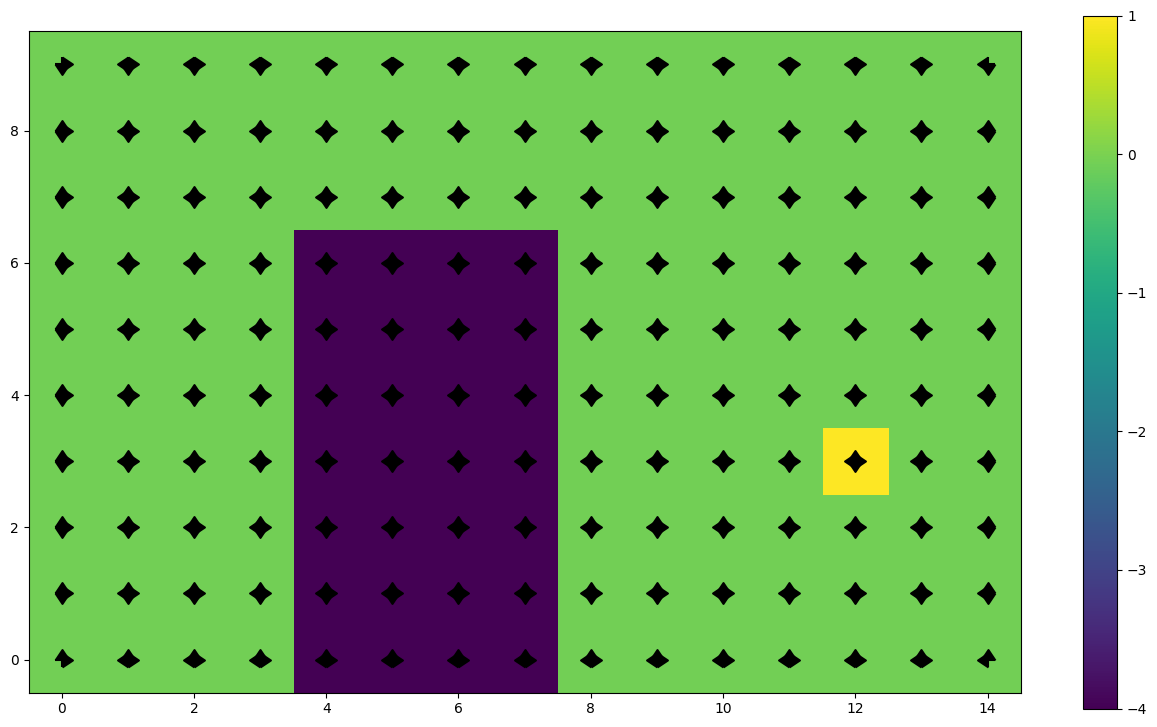

In [5]:
show_qmat(Q, world=w)

# Hyperparameters

__alpha__ ($0<\alpha<1$):
The    learning    rate.    A    value    close    to    0    puts    more    emphasis    on    already    learned   experience and    a    value    close    to    1    will    overwrite    previous    experience    with    new    information.    Good    value    to    start    with:    0.1-0.5

__gamma__ ($0<\gamma<1$):
    The    discount    factor.    A    value    close    to    0    will    seek    to    maximize    short-term    rewards whereas    a    value    close    to    1    will    focus    the    learning    on    long    term    rewards.    Good    value    to    start    with:    around    0.9

__epsilon__ ($0<\epsilon<1$):
    Exploration    factor    –    the    probability    of    choosing    a    random    action.    A    value    close    to 1 will    make    the    learning    focus    on    exploration    and    a    value    close    to    0    will    make    the system    take    actions    based    on    already    learned    experience.    Explore    a    lot    in    the    beginning (large    ε) and    focus    the    search    more    around    the    good    policies    towards    the    end    (small    ε).

$Q(S_t, A_k) := (1-\alpha) * Q(S_t, A_k) + \alpha * (reward + \gamma * V(S_{t+1}))$

$V(S_t) = \max\limits_{A}{Q(S_t, A)}$

In [6]:
def train_episode(world, q_mat, alpha, epsilon, gamma):
    reply = {"is_terminal": False}
    while not reply["is_terminal"]:
        start_state = world.current_state

        actions = world.get_legal_actions()
        if np.random.uniform() >= epsilon:
            m = q_mat[start_state][actions].max()
            actions = [a for a in actions if q_mat[start_state][a] == m]
        
        d = np.random.choice(actions)
        reply = world.perform_action(d)
        if not reply["is_valid"]:
            raise Exception(f"Invalid: {world.current_state} + {d}")

        reward = reply["reward"]
        q_mat[(*start_state, d)] *= (1 - alpha)
        q_mat[(*start_state, d)] += alpha * (reward + gamma * q_mat[world.current_state].max())

    return q_mat

In [7]:
from importlib import reload
reload(qlearning)

w = Wormhole() 
print(w.size)

# Maps an immediate reward/cost for every position-action pair
Q = np.zeros(tuple(w.size) + (len(w.actions), ))
Q[:, 0, 0] = Q[:, -1, 1] = Q[-1, :, 2] = Q[0, :, 3] = -np.inf

V = np.max(Q, axis=-1)

[10 15]


In [8]:
n_episodes = 1000
for i in trange(n_episodes, ascii=True):
    Q = train_episode(w, Q, .5, .9, .9)

  0%|          | 0/1000 [00:00<?, ?it/s]

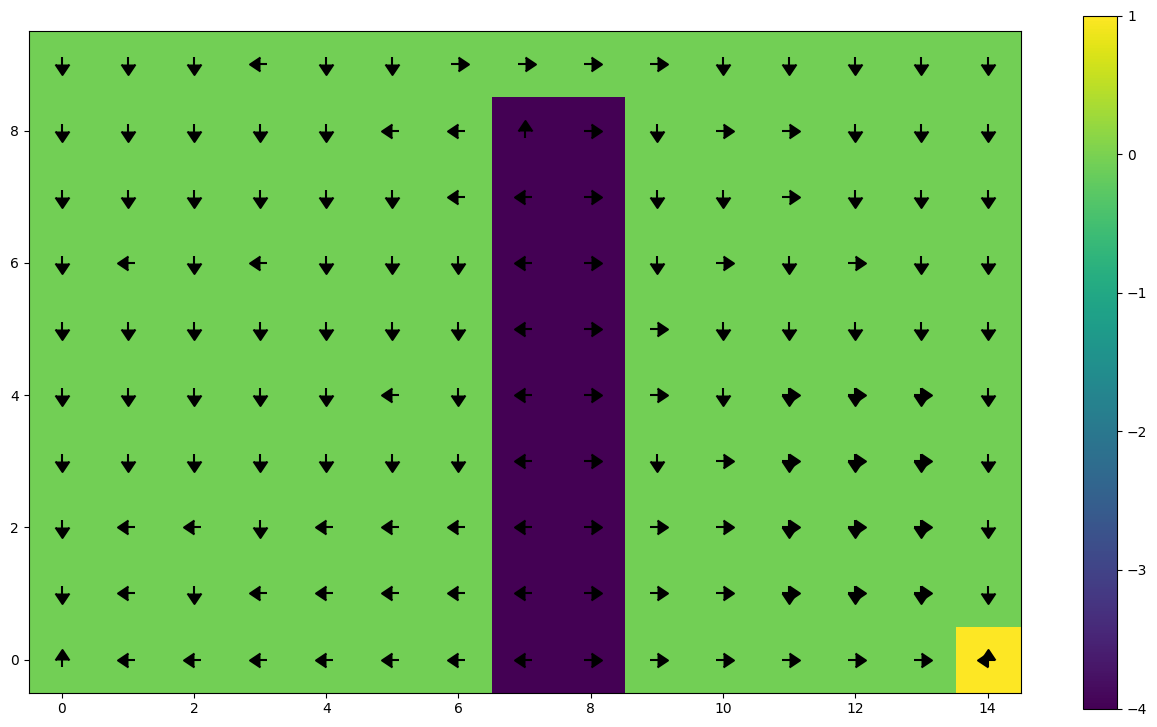

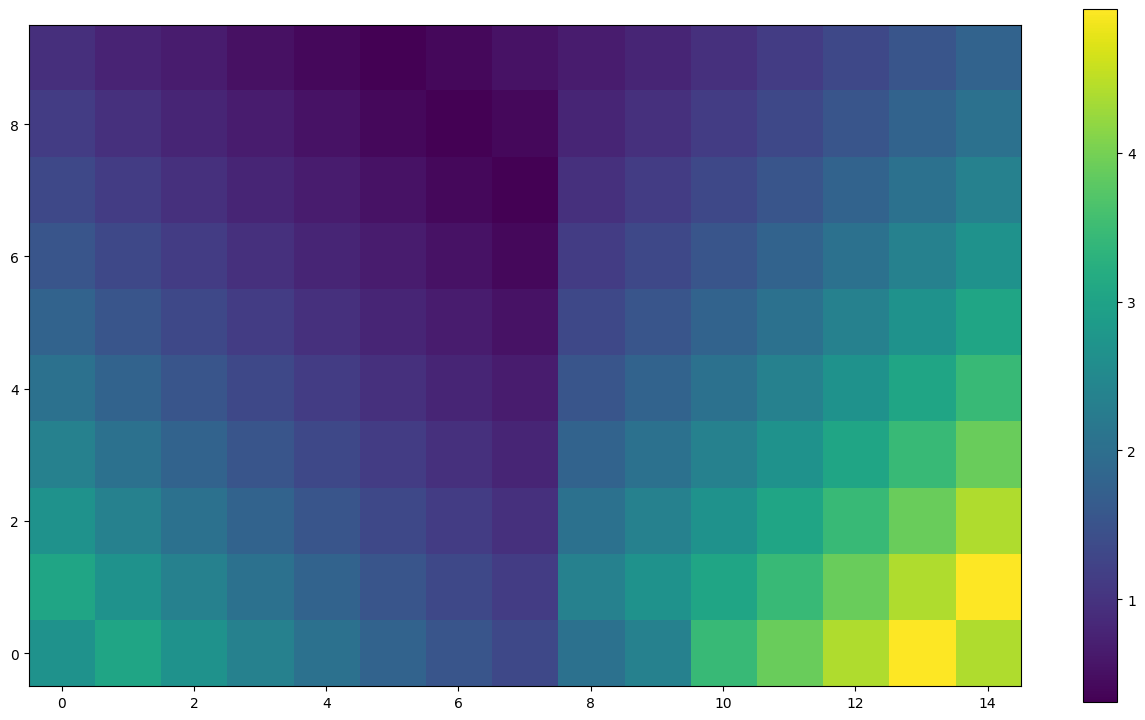

In [9]:
show_qmat(Q, world=w)
plt.show()
plt.imshow(Q.max(axis=-1), origin='lower')
plt.colorbar()

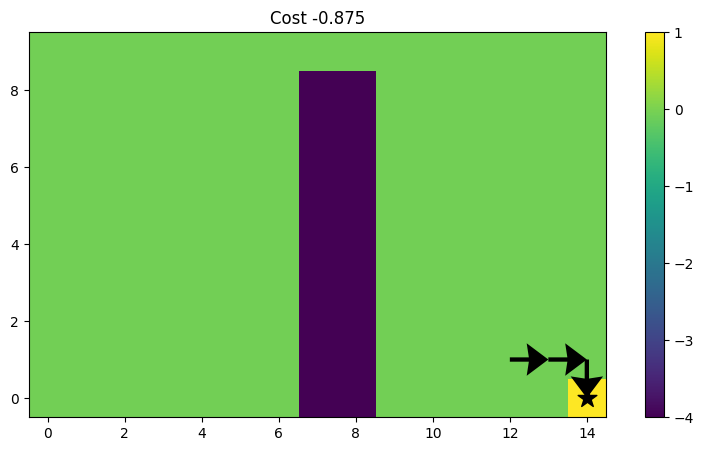

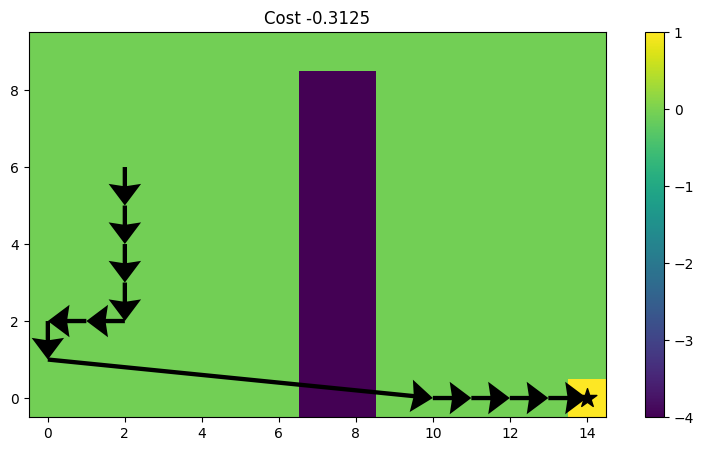

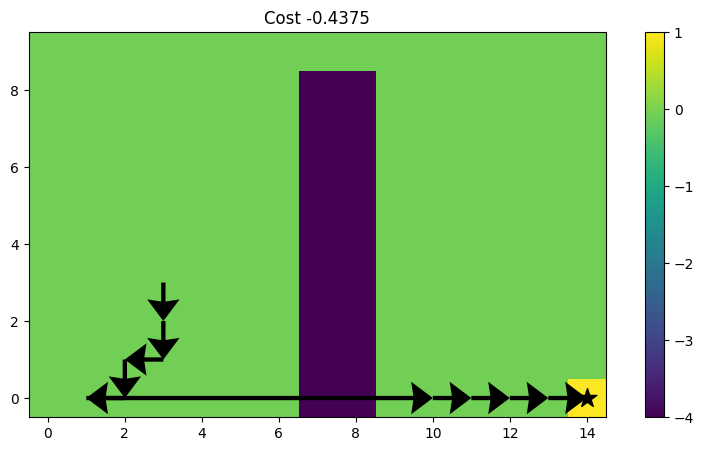

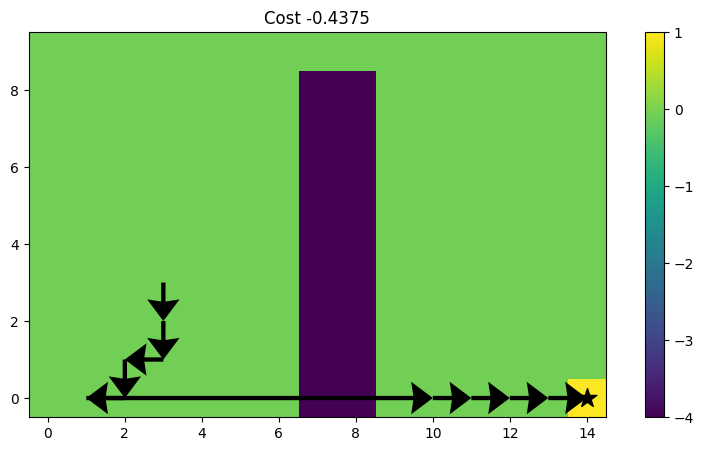

In [10]:
for _ in range(4):
    w.reset()
    path, cost = w.run(Q)
    plt.figure(figsize=(10, 5))
    show_path(path, world=w)
    plt.title(f'Cost {cost}')
    plt.show()

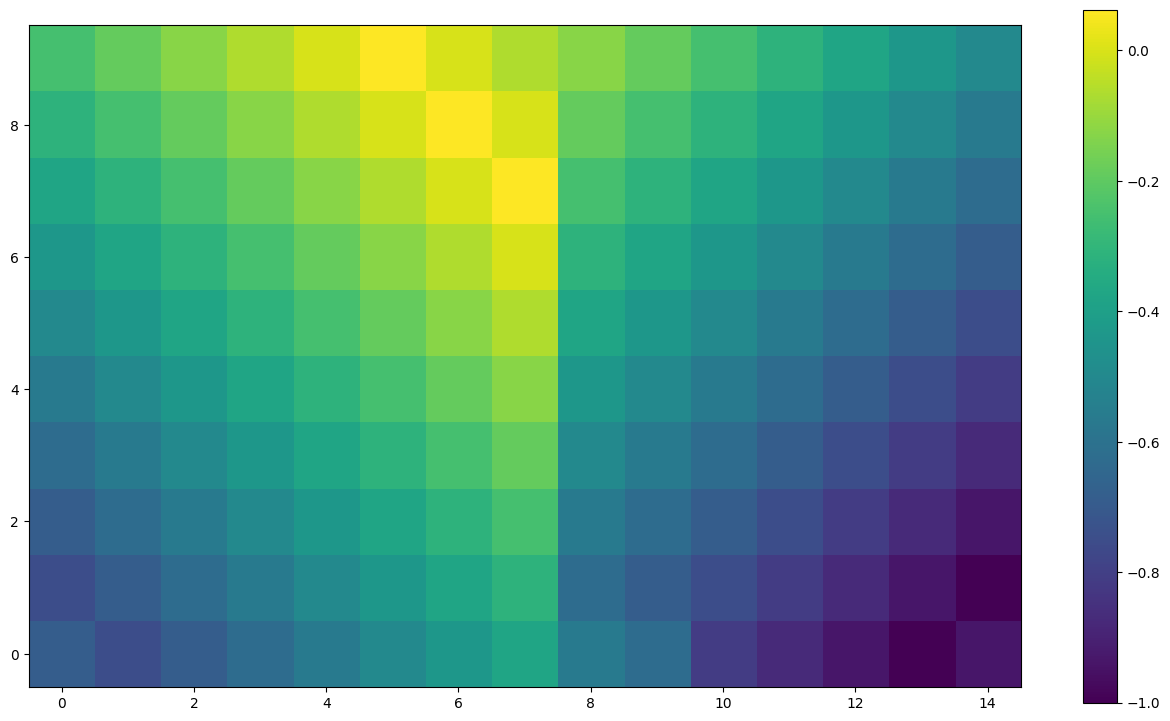

In [11]:
costs = w.evaluate(Q)
plt.imshow(costs, origin='lower')
plt.colorbar()
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error

In [13]:
q_net = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=.1)

In [14]:
w = LakeWorld()

In [15]:
epsilon = .2

for epoch in range(100):
    w.reset()
    state = tf.constant([w.current_state])
    
    total = 0
    for episode in tqdm(range(1000)):
        with tf.GradientTape() as tape:
            # Obtain Q-values from network
            q_values = q_net(state)

            # Masking out illegal moves
            cond = w.get_legal_actions(as_mask=True)
            q_values_legal = tf.where(cond, q_values, -np.inf)

            if not cond.any():
                raise RuntimeError('Model cannot take any legal action anymore!')

            if np.random.rand() <= epsilon:
                # Select random action
                action = np.random.choice(w.get_legal_actions())
            else:
                # Select action with highest q-value
                action = np.argmax(q_values_legal)

            # Obtain reward from bandit
            result = w.perform_action(action)
            reward, state, is_terminal = result['reward'], tf.constant([result['pos']]), result['is_terminal']
            total += reward

            # Obtain Q-value
            q_value = q_values[0, action]

            # Compute loss value
            loss_value = mean_squared_error(tf.reshape(q_value, (1, -1)), tf.constant([reward]))

            # Compute gradients
            grads = tape.gradient(loss_value[0], q_net.trainable_variables)

            # Apply gradients to update network weights
            optimizer.apply_gradients(zip(grads, q_net.trainable_variables))

            # Print console output
            # if np.mod(i, 100) == 0:
            #     print("\n======episode", episode, "======")
            #     print("Q-values", ["%.3f" % n for n in q_values[0]])

            if is_terminal:
                break
                
    print(total)

  0%|          | 0/1000 [00:00<?, ?it/s]

-82.1875


  0%|          | 0/1000 [00:00<?, ?it/s]

-145.1875


  0%|          | 0/1000 [00:00<?, ?it/s]

-109.75


  0%|          | 0/1000 [00:00<?, ?it/s]

-66.6875


  0%|          | 0/1000 [00:00<?, ?it/s]

-86.125


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-66.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-204.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-27.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-111.0


  0%|          | 0/1000 [00:00<?, ?it/s]

-4.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-145.1875


  0%|          | 0/1000 [00:00<?, ?it/s]

-72.8125


  0%|          | 0/1000 [00:00<?, ?it/s]

-34.5625


  0%|          | 0/1000 [00:00<?, ?it/s]

-12.375


  0%|          | 0/1000 [00:00<?, ?it/s]

-117.625


  0%|          | 0/1000 [00:00<?, ?it/s]

-67.5625


  0%|          | 0/1000 [00:00<?, ?it/s]

-66.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-160.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-15.375


  0%|          | 0/1000 [00:00<?, ?it/s]

-22.1875


  0%|          | 0/1000 [00:00<?, ?it/s]

-21.5625


  0%|          | 0/1000 [00:00<?, ?it/s]

-105.8125


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-133.375


  0%|          | 0/1000 [00:00<?, ?it/s]

-113.6875


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-73.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-98.0625


  0%|          | 0/1000 [00:00<?, ?it/s]

-121.5625


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-160.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-129.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-105.8125


  0%|          | 0/1000 [00:00<?, ?it/s]

-22.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-7.625


  0%|          | 0/1000 [00:00<?, ?it/s]

-157.0


  0%|          | 0/1000 [00:00<?, ?it/s]

-4.1875


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-149.125


  0%|          | 0/1000 [00:00<?, ?it/s]

-13.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-48.6875


  0%|          | 0/1000 [00:00<?, ?it/s]

-86.125


  0%|          | 0/1000 [00:00<?, ?it/s]

-160.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-164.875


  0%|          | 0/1000 [00:00<?, ?it/s]

-19.0625


  0%|          | 0/1000 [00:00<?, ?it/s]

-30.0


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-177.625


  0%|          | 0/1000 [00:00<?, ?it/s]

-94.0


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-66.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-66.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-66.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-94.8125


  0%|          | 0/1000 [00:00<?, ?it/s]

-137.3125


  0%|          | 0/1000 [00:00<?, ?it/s]

-118.6875


  0%|          | 0/1000 [00:00<?, ?it/s]

-88.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-17.75


  0%|          | 0/1000 [00:00<?, ?it/s]

-44.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

-71.125


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-10.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-20.75


  0%|          | 0/1000 [00:00<?, ?it/s]

-133.3125


  0%|          | 0/1000 [00:00<?, ?it/s]

-9.6875


  0%|          | 0/1000 [00:00<?, ?it/s]

-86.125


  0%|          | 0/1000 [00:00<?, ?it/s]

-86.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-50.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-94.0


  0%|          | 0/1000 [00:00<?, ?it/s]

-160.9375


  0%|          | 0/1000 [00:00<?, ?it/s]

-117.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-117.625


  0%|          | 0/1000 [00:00<?, ?it/s]

-149.125


  0%|          | 0/1000 [00:00<?, ?it/s]

-121.5625


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-47.375


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-90.0625


  0%|          | 0/1000 [00:00<?, ?it/s]

-86.125


  0%|          | 0/1000 [00:00<?, ?it/s]

-30.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-14.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-62.5


  0%|          | 0/1000 [00:00<?, ?it/s]

-35.1875
